# DeepLabCut Toolbox - DEMO for maDLC
https://github.com/AlexEMG/DeepLabCut

#### The notebook accompanies the following preprint:

*Multi-animal pose estimation and tracking with DeepLabCut.* A. Mathis et al, 2020 in prep.

This notebook illustrates how to:

- create a multi-animal project
- label the data 
- check the labels 
- create a multi-animal training dataset
- train your new deep neural network 
- evaluate network
- analyze videos

### You must have deeplabcut 2.2 installed (upgrade here if needed):

In [ ]:
!pip install --upgrade deeplabcut

In [1]:
%cd '/home/mackenzie/DEEPLABCUT/maDLC/DLCdev'

/home/mackenzie/DEEPLABCUT/maDLC/DLCdev


## Import the toolbox:

In [2]:
!export DLClight=False
import deeplabcut
deeplabcut.__file__

'/home/mackenzie/DEEPLABCUT/maDLC/DLCdev/deeplabcut/__init__.py'

# Create a new project

It is always good idea to keep the projects seperate if you want to use different networks to analze your data. You should use one project if you are tracking similar subjects/items even if in different environments. This function creates a new project with sub-directories and a basic configuration file in the user defined directory otherwise the project is created in the current working directory.

In [7]:
task='mwm' # Enter the name of your experiment Task
experimenter='penguins' # Enter the name of the experimenter
video=['/home/mackenzie/Desktop/penguindemo.mp4'] # Enter the paths of your videos OR FOLDER you want to grab frames from.
#CRUCIAL: you should take as diverse frames as possible from multiple videos and animals!

deeplabcut.create_new_project(task,experimenter,video,copy_videos=True, multianimal=True) 

# NOTE: The function returns the path, where your project is. 
# You could also enter this manually (e.g. if the project is already created and you want to pick up, where you stopped...)
#path_config_file = '/home/Mackenzie/myDLCProjectFolders/config.yaml' # Enter the path of the config file that was just created from the above step (check the folder)

Created "/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/videos"
Created "/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data"
Created "/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/training-datasets"
Created "/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models"
Copying the videos
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/videos/penguindemo.mp4
Generated "/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/config.yaml"

A new project with name mwm-penguins-2020-03-31 is created at /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2 and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' to select frames for labeling.
. [OPTIONAL] Use the function 'add_new_videos' to add new videos to your project (at any stage).


'/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/config.yaml'

In [3]:
#set path to config.yaml file (printed above!)
path_config_file = '/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/config.yaml'

# CRUCIAL: go edit the config.yaml file that was created! 

You will have a config.yaml file in your project folder. 
Crucially, please set:

- **individuals**
        #set the number of animals, i.e. "indiv1, indiv2, indiv3" up to the maximum you expect to see!
- **uniquebodyparts** 
        #this are points that are not tied to an individual, i.e. something like "cornerofabox" or "LED"
- **multianimalbodyparts** 
        #this is the real bodypart per individual list (as in "normal" DLC). Please use more body parts than 
         you might have been used to previously. Now that a skeleton is used for training you want to be able
         to  connect close parts.
- **skeleton** 
         #this is now used during training, so please connect the bodyparts in a graph

Plus, edit the number of frames to extract per video, etc. 

# Extract frames from videos 
A key point for a successful feature detector is to select diverse frames, which are typical for the behavior you study that should be labeled.

This function selects N frames either uniformly sampled from a particular video (or folder) ('uniform'). Note: this might not yield diverse frames, if the behavior is sparsely distributed (consider using kmeans), and/or select frames manually etc.

Also make sure to get select data from different (behavioral) sessions and different animals if those vary substantially (to train an invariant feature detector).

Individual images should not be too big (i.e. < 850 x 850 pixel). Although this can be taken care of later as well, it is advisable to crop the frames, to remove unnecessary parts of the frame as much as possible.

Always check the output of cropping. If you are happy with the results proceed to labeling.

In [ ]:
#AUTOMATIC:
deeplabcut.extract_frames(path_config_file) 

# Label Frames

In [ ]:
deeplabcut.label_frames(path_config_file)

# Check Labels, by bodypart:

In [22]:
deeplabcut.check_labels(path_config_file, visualizeindividuals=False)

Creating images with labels by penguins.
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data/penguindemo_labeled  already exists!
They are stored in the following folder: /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data/penguindemo_labeled.
Plotting labels for multi animal project.
If all the labels are ok, then use the function 'create_training_dataset' to create the training dataset!


# Check Labels, by individual:

You can run this function "again" with the flag set to true and it saves both sets of images.

In [21]:
deeplabcut.check_labels(path_config_file, visualizeindividuals=True)

Creating images with labels by penguins.
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data/penguindemo_labeled  already exists!
They are stored in the following folder: /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data/penguindemo_labeled.
Plotting labels for multi animal project.
If all the labels are ok, then use the function 'create_training_dataset' to create the training dataset!


### Here we have an extra (optional but recommended) step to crop and diversify the images before creating the training set: 

This is recommended to be able to train in batches, and especially helpful if you have lots of animals. It's worth the few minutes... plus you can then use batch training if your images were not the same size already.

In [23]:
deeplabcut.cropimagesandlabels(path_config_file, userfeedback=False)

Do you want to crop frames for folder:  /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/labeled-data/penguindemo ?
(yes/no):y


20it [00:58,  2.93s/it]


# Create maDLC training dataset:

Here you have several options (as always), and some new defaults! Defaults: firstly, this will use ResNet-50 with imgaug and  secondly, new ADAM optimizer with batch training (if your frames are the same size*). 

In [25]:
deeplabcut.create_multianimaltraining_dataset(path_config_file)

  1%|          | 2/190 [00:00<00:13, 14.39it/s]

{'head': 0, 'neck': 1, 'body': 2, 'wing1': 3, 'wing2': 4, 'cornerofbox': 5}
['head', 'neck'] 0
['neck', 'wing1'] 1
['neck', 'wing2'] 1
['neck', 'body'] 1
[0, 1] head neck
[1, 3] neck wing1
[1, 4] neck wing2
[1, 2] neck body
Utilizing the following graph: [[0, 1], [1, 3], [1, 4], [1, 2]]
Creating training data for  1 0.95
This can take some time...


100%|██████████| 190/190 [00:11<00:00, 17.03it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


## Start training the multi-task DNN + Feature Detectors:
This function trains the network for a specific shuffle of the training dataset. 

Training can be stopped at any time w/CNTRL+C. Note that the weights are only stored every 'saveiters' steps. Inn reality, you will train until ~50K, so we save every 10K). But, you can store more frequently or display more fequently if you are DEMOing the code. Note, this is a *NEW* training regime, so if you are used to DLC 2.1 (and before), this now takes less time to train.


In [26]:
deeplabcut.train_network(path_config_file, shuffle=1, saveiters=1000, displayiters=100, maxiters=50000)
#notice the variables "saveiters" and "dsiplayiters" that can be set in the function

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5]],
 'all_joints_names': ['head', 'neck', 'body', 'wing1', 'wing2', 'cornerofbox'],
 'batch_size': 16,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_mwmMar31/mwm_penguins95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'display_iters': 500,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-0/UnaugmentedDataSet_mwmMar31/Documentation_data-mwm_95shuffle1.pi

Selecting multi-animal trainer
Activating limb prediction...
Starting with multi-animal imaug + adam pose-dataset loader.
Batch Size is 16
Getting specs multi-animal-imgaug 4 6
Initializing ResNet
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading ImageNet-pretrained resnet_50
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt
Max_iters overwritten as 50000
Display_iters overwritten as 100
Save_iters overwritten as 1000
Training parameters:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shu

iteration: 100 loss: 0.0730 scmap loss: 0.0575 locref loss: 0.0036 limb loss: 0.0118 lr: 0.0001
iteration: 200 loss: 0.0242 scmap loss: 0.0219 locref loss: 0.0007 limb loss: 0.0017 lr: 0.0001
iteration: 300 loss: 0.0201 scmap loss: 0.0182 locref loss: 0.0005 limb loss: 0.0014 lr: 0.0001
iteration: 400 loss: 0.0170 scmap loss: 0.0153 locref loss: 0.0005 limb loss: 0.0012 lr: 0.0001
iteration: 500 loss: 0.0148 scmap loss: 0.0133 locref loss: 0.0004 limb loss: 0.0011 lr: 0.0001
iteration: 600 loss: 0.0125 scmap loss: 0.0112 locref loss: 0.0004 limb loss: 0.0009 lr: 0.0001
iteration: 700 loss: 0.0119 scmap loss: 0.0107 locref loss: 0.0004 limb loss: 0.0009 lr: 0.0001
iteration: 800 loss: 0.0111 scmap loss: 0.0099 locref loss: 0.0003 limb loss: 0.0008 lr: 0.0001
iteration: 900 loss: 0.0102 scmap loss: 0.0092 locref loss: 0.0003 limb loss: 0.0007 lr: 0.0001
iteration: 1000 loss: 0.0102 scmap loss: 0.0092 locref loss: 0.0003 limb loss: 0.0007 lr: 0.0001
iteration: 1100 loss: 0.0100 scmap loss

Instructions for updating:
Use standard file APIs to delete files with this prefix.


iteration: 6100 loss: 0.0044 scmap loss: 0.0040 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 6200 loss: 0.0042 scmap loss: 0.0039 locref loss: 0.0001 limb loss: 0.0002 lr: 0.0001
iteration: 6300 loss: 0.0042 scmap loss: 0.0038 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 6400 loss: 0.0043 scmap loss: 0.0039 locref loss: 0.0001 limb loss: 0.0002 lr: 0.0001
iteration: 6500 loss: 0.0041 scmap loss: 0.0038 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 6600 loss: 0.0042 scmap loss: 0.0038 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 6700 loss: 0.0041 scmap loss: 0.0037 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 6800 loss: 0.0040 scmap loss: 0.0037 locref loss: 0.0001 limb loss: 0.0002 lr: 0.0001
iteration: 6900 loss: 0.0039 scmap loss: 0.0036 locref loss: 0.0001 limb loss: 0.0002 lr: 0.0001
iteration: 7000 loss: 0.0037 scmap loss: 0.0034 locref loss: 0.0001 limb loss: 0.0003 lr: 0.0001
iteration: 7100 loss: 0.0040 s

KeyboardInterrupt: 

## Evaluate the trained network

This function evaluates a trained model for a specific shuffle/shuffles at a particular training state (snapshot) or on all the states. The network is evaluated on the data set (images) and stores the results as .csv file in a subdirectory under **evaluation-results**.

You can change various parameters in the ```config.yaml``` file of this project. For the evaluation one can change pcutoff. This cutoff also influences how likely estimated postions need to be so that they are shown in the plots.

In [34]:
trainposeconfigfile,testposeconfigfile,snapshotfolder=deeplabcut.return_train_network_path(path_config_file)
cfg_dlc=deeplabcut.auxiliaryfunctions.read_plainconfig(testposeconfigfile)
  #cfg_dlc['partaffinityfield_predict']=True
  #cfg_dlc['dataset_type']='multi-animal-imgaug'
cfg_dlc['nmsradius']=5.
cfg_dlc['minconfidence']=.05
deeplabcut.auxiliaryfunctions.write_plainconfig(testposeconfigfile,cfg_dlc)

In [35]:
deeplabcut.evaluate_network(path_config_file,plotting=True,c_engine=False)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5]],
 'all_joints_names': ['head', 'neck', 'body', 'wing1', 'wing2', 'cornerofbox'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_mwmMar31/mwm_penguins95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'display_iters': 500,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-0/UnaugmentedDataSet_mwmMar31/Documentation_data-mwm_95shuffle1.pic

/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/  already exists!
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/iteration-0/mwmMar31-trainset95shuffle1  already exists!
Running  DLC_resnet50_mwmMar31shuffle1_12000  with # of trainingiterations: 12000
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/iteration-0/mwmMar31-trainset95shuffle1/LabeledImages_DLC_resnet50_mwmMar31shuffle1_12000_snapshot-12000  already exists!
Initializing ResNet
Activating extracting of PAFs
INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle1/train/snapshot-12000


0it [00:00, ?it/s]

Analyzing data...


200it [01:38,  2.02it/s]

Done and results stored for snapshot:  snapshot-12000


## Analyzing videos
This function extracts the pose based on a trained network from videos. The user can choose the trained network - by default the most recent snapshot is used to analyse the videos. However, the user can also specify the snapshot index for the variable **snapshotindex** in the **config.yaml** file).

The results are stored in hd5 file in the same directory, where the video resides. The pose array (pose vs. frame index) can also be exported as csv file (set flag to...). 

In [4]:
# Set the video path:
#The video can be the one you trained with and new videos that look similar, i.e. same experiments, etc.
# You can add individual videos, OR just a folder - it will skip videos that are already analyzed once.

videofile_path = '/home/mackenzie/Desktop/penguindemo.mp4'      

In [5]:
print("Start Analyzing the video!")
deeplabcut.analyze_videos(path_config_file,[videofile_path], videotype='.mp4', c_engine=False)

#NOTE: c_engine = True is faster, but requires you complie c code first.  Please run complie.sh first!

Start Analyzing the video!
Using snapshot-12000 for model /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle1
Initializing ResNet
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Activating extracting of PAFs
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle1/train/snapshot-12000


INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle1/train/snapshot-12000


Starting to analyze %  /home/mackenzie/Desktop/penguindemo.mp4
Video already analyzed! /home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle1_12000.h5
The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


'DLC_resnet50_mwmMar31shuffle1_12000'

## Check predictions visually before moving onwards:

This function will create a video withthe ending "full" you can view. This is ONLY the detections! 

In [13]:
deeplabcut.create_video_with_all_detections?

In [6]:
#You input the config path, video path, and then the scorer path:
scorername = 'DLC_resnet50_mwmMar31shuffle1_12000'

deeplabcut.create_video_with_all_detections(path_config_file, videofile_path, scorername)

Detections already plotted,  /home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle1_12000_full.mp4


In [26]:
deeplabcut.extract_maps?

In [ ]:
deeplabcut.extract_maps(path_config_file, shuffle=1, Indices=[0,103])

#insane printing  here ... does not make the actualy plots. 

## Create the Multi-Animal Tracklets! 

Please note, this has quite a few parameters, and they need to be cross-validated for best performance. 

Thus, for eah project we strongly suggest you take the time to cross-validate. 

Here is how... 

In [22]:
deeplabcut.convert_detections2tracklets?

In [7]:
#assemble tracklets:
deeplabcut.convert_detections2tracklets(path_config_file,[videofile_path],videotype='mp4')

#issue:
#https://github.com/AlexEMG/DLCdev/blob/ad0282d60cee4990a73e1126e9a43052b42ae36f/deeplabcut/pose_estimation_tensorflow/predict_videos.py#L803

0it [00:00, ?it/s]

Using snapshot-12000 for model /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle1
['/home/mackenzie/Desktop/penguindemo.mp4']
Processing...  /home/mackenzie/Desktop/penguindemo.mp4
Analyzing /home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle1_12000.h5


70it [00:07,  9.25it/s]

The videos were analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract any outlier frames!


## Now you should manually verfiy the tracks and correct them if needed! 

In [16]:
deeplabcut.refine_tracklets?

<IPython.core.display.Javascript object>


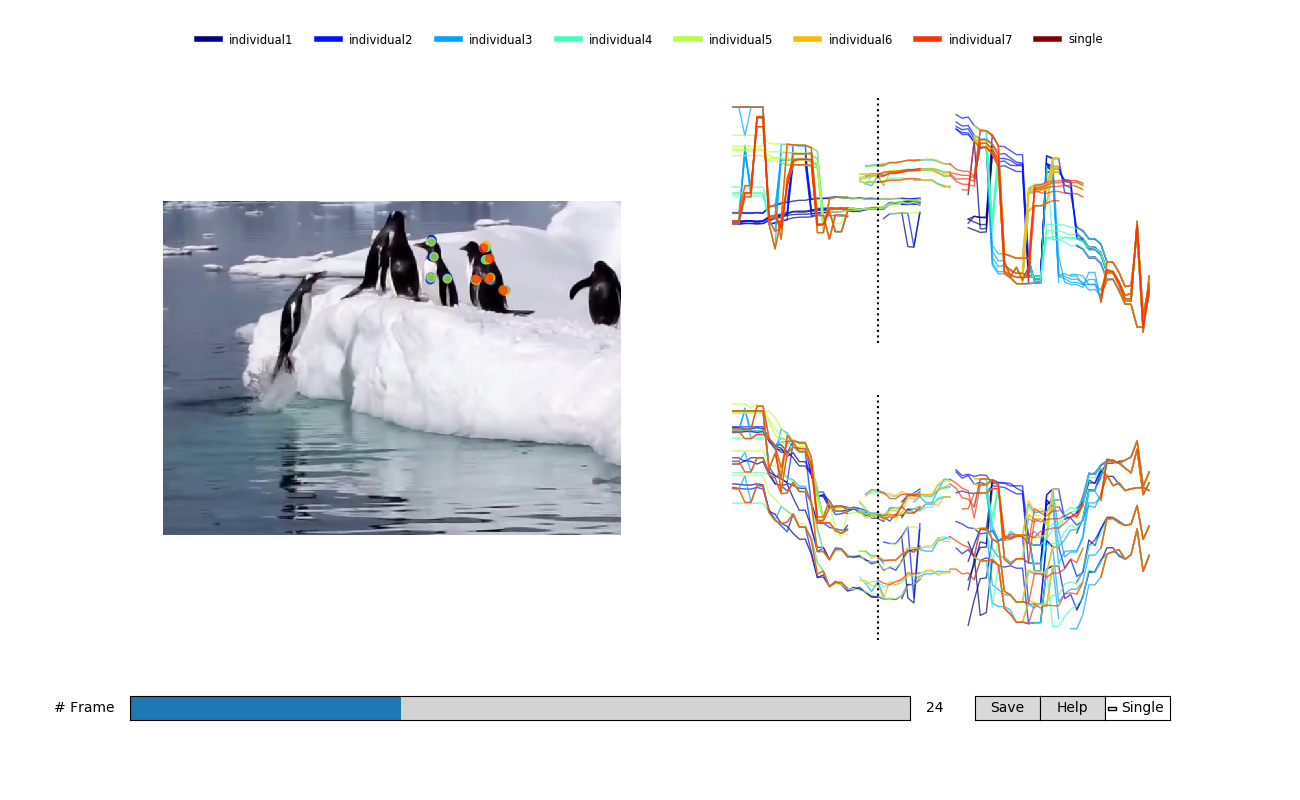

In [17]:
%matplotlib notebook
picklefile ='/home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle1_12000tracks.pickle'
deeplabcut.refine_tracklets(path_config_file, picklefile, videofile_path, min_swap_frac=0,min_tracklet_frac=0)

## Create labeled video

This function is for the visualization purpose and can be used to create a video in .mp4 format with the predicted labels. This video is saved in the same directory, where the (unlabeled) video resides. 

Various parameters can be set with regard to the colormap and the dotsize (matplotlib is used in the backend). See the config.yaml file for how to set these.

In [20]:
deeplabcut.create_labeled_video(path_config_file,[videofile_path], draw_skeleton=True)

## Plot the trajectories of the analyzed videos
This function plots the trajectories of all the body parts across the entire video. Each body part is identified by a unique color. The underlying functions can easily be customized.

In [21]:
%matplotlib notebook
deeplabcut.plot_trajectories(path_config_file,[videofile_path],showfigures=True)

#These plots can are interactive and can be customized (see https://matplotlib.org/)

Plots created! Please check the directory "plot-poses" within the video directory


## Extract outlier frames, where the predictions are off.

This is optional step allows to add more training data when the evaluation results are poor. In such a case, the user can use the following function to extract frames where the labels are incorrectly predicted. Make sure to provide the correct value of the "iterations" as it will be used to create the unique directory where the extracted frames will be saved.

In [ ]:
# Note, if you have questions on parameters, remember "?" gives you answers:
deeplabcut.extract_outlier_frames?

In [ ]:
deeplabcut.extract_outlier_frames(path_config_file,videofile_path,outlieralgorithm='uncertain',p_bound=.2)

The user can run this iteratively, and (even) extract additional frames from the same video.

## Manually correct labels

This step allows the user to correct the labels in the extracted frames. Navigate to the folder with the videos and use the GUI as described in the protocol to update the labels.

In [ ]:
#GUI pops up! 
#sometimes you need to restart the kernel for the GUI to launch.
%gui wx
deeplabcut.refine_labels(path_config_file)

In [ ]:
# Now merge datasets (once you refined all frames)
deeplabcut.merge_datasets(path_config_file)

## Create a new iteration of training dataset, check it and train...

Following the refine labels, append these frames to the original dataset to create a new iteration of training dataset.

In [ ]:
#Perhaps plot the labels to see how how all the frames are annotated (including the refined ones)
deeplabcut.check_labels(path_config_file)
# if they are off, you can load them in the labeling_gui to adjust!

In [ ]:
deeplabcut.create_training_dataset(path_config_file)

Now one can train the network again... (with the expanded data set)

In [ ]:
deeplabcut.train_network(path_config_file)